# [Lab] Recurrent Neural Network

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

## 1. Generate some input data (X) consisting of 30 sequences of 8 binary numbers, following a uniform distribution, where the probability of generating a “0” is the same as that of generating a “1”. Make the output (y) for each sequence be the sum of its elements.

In [2]:
I = 30 # Number of training examples
T = 8  # Length of the sequence
n, p = 1, .5
X = np.random.binomial(n, p, (I,T))
Y = []
for x in X:
    Y = np.append(Y,np.sum(x))
Y = Y.reshape(I,1)

In [3]:
alpha_x_bak=0.0001
alpha_f_bak=0.0001
epsilon = 1400

delta_init = 0.0003
eta_n = 0.5
eta_p = 1.2

alpha_x_cli=0.001
alpha_f_cli=0.001
eta = 5

## 2.Implement a sequential adder using the Elman recurrent neural network (RNN) with

In [4]:
def forward_prop(X,Vx,Vf):
    """ function for the forward propagation phase of our RNN
        returns the final results after the whole sequence has been treated
    """
    Ft = np.zeros(X.shape[0]) #current output we c
    F = np.zeros(X.shape) #to store intermediate values of Ft
    for t in range(X.shape[1]): 
        F[:,t] = Ft
        Ft = Vf * Ft + Vx * X[:,t]
    return Ft.reshape(X.shape[0],1),F

### a) backpropagation,

In [5]:
def sse(Y,predictions):
    return 0.5*np.sum(np.square(predictions-Y))

In [6]:
def compute_dE(X,F,Y,predictions,Vx,Vf):
    dEVx = 0
    dEVf = 0
    T = X.shape[1]
    for t in range(T):
        sx = 0
        sf = 0
        for i,x in enumerate(X):
            sx += (predictions[i]-Y[i])*x[t]
            sf += (predictions[i]-Y[i])*F[i][t]
        c = (Vf**(T-t+1))
        dEVx += sx * c
        dEVf += sf * c
    return dEVx,dEVf

In [7]:
def back_prop(X,F,Y,predictions,Vx,Vf,alphax,alphaf):
    """ vanilla backpropagation function
        this is called at each batch or foward pass
        updates the values of the parameters and returns Vf and Vx
    """    
    dEVx,dEVf = compute_dE(X,F,Y,predictions,Vx,Vf)
    Vx -= (alphax * dEVx)   
    Vf -= (alphaf * dEVf)
    #print("dEVx :",dEVx,"dEVf :",dEVf)
    #print("Vx :",Vx,"Vf :",Vf)
    return Vx,Vf,dEVx,dEVf

In [8]:
#train fonction for the backpropagation algorithm
#Outputs the optimal weights and the errors during training
def train_back(X,Y,alphax, alphaf, epsilon,Vx, Vf):
    SSE = []    #Array to store all SSE over time
    Vx_evo = [] #Array to store all Vx over time
    Vf_evo = [] #Array to store all Vf over time
    dEVx_evo = [] #Array to store all dEVx over time
    dEVf_evo = [] #Array to store all dEVf over time
    
    diff_error = epsilon+1
    prev_diff_error = diff_error
    prev_error = 0
    
    n_iter = 0
    stop_loop=0
    for p in range(400):
    #while(stop_loop !=3):
        n_iter+=1
        predictions,F = forward_prop(X,Vx,Vf)
        cur_error= sse(Y,predictions)
        SSE = np.append(SSE,cur_error)
        
        Vf,Vx,dEVx,dEVf = back_prop(X,F,Y,predictions,Vx,Vf,alphax,alphaf)
        Vx_evo = np.append(Vx_evo,Vx)
        Vf_evo = np.append(Vf_evo,Vf)
        dEVx_evo = np.append(dEVx_evo,dEVx)
        dEVf_evo = np.append(dEVf_evo,dEVf)
        
        prev_diff_error = diff_error
        if(n_iter>1):
            diff_error = abs(cur_error - prev_error)
        prev_error = cur_error
        #clear_output()
        print("Training #",n_iter," Diff SSE: ",diff_error, " SSE : ",cur_error)
        print("dEVx :",dEVx,"dEVf :",dEVf)
        print("Vx :",Vx,"Vf :",Vf)
        print("__________________________________________________________________")
        if(cur_error < epsilon): #if the current and previous error difference is lesser than espilon, increment the stopping variable
            stop_loop+=1
        else :
            stop_loop = 0
    print("Finished after {} iterations, finals weights Vx {} Vf {}".format(n_iter,Vx,Vf))
    return Vx_evo,Vf_evo,dEVx_evo,dEVf_evo,SSE

### b) resilient propagation

In [9]:
#function returning the sign of the input
#def sign(x): return math.copysign(1, x)

#Train a resilient backpropagation model
#Outputs the optimal weights and the errors during training
def train_resilient(X,y, delta_init, eta_p, eta_n,epsilon, Vx, Vf):
    SSE = []    #Array to store all SSE over time
    Vx_evo = [] #Array to store all Vx over time
    Vf_evo = [] #Array to store all Vf over time
    dEVx_evo = [] #Array to store all dEVx over time
    dEVf_evo = [] #Array to store all dEVf over time
    
    delta_f = delta_init
    delta_x = delta_init
    diff_error = 0.0
    prev_diff_error = diff_error
    prev_error = 0
    cur_error = 0
    dEVx,dEVf = 0,0
    
    stop_loop=0
    n_iter=0
    
    for p in range(400):
    #while(stop_loop !=3): #Loop while we don't have three consecutive error differences lesser than epsilon, meaning we converged                
        n_iter+=1                
        
        predictions,F = forward_prop(X,Vx,Vf)

        #save previous derivative for sign comparison
        prev_dEVx=dEVx
        prev_dEVf=dEVf
        
        dEVx,dEVf = compute_dE(X,F,Y,predictions,Vx,Vf)

        if np.sign(prev_dEVx) == np.sign(dEVx):
            delta_x *= eta_p
        else:
            delta_x *= eta_n
            
        if np.sign(prev_dEVf) == np.sign(dEVf):
            delta_f *= eta_p
        else:
            delta_f *= eta_n

        Vx -= np.sign(dEVx) * delta_x
        Vf -= np.sign(dEVf) * delta_f
            
        Vx_evo = np.append(Vx_evo,Vx)
        Vf_evo = np.append(Vf_evo,Vf)
        dEVx_evo = np.append(dEVx_evo,dEVx)
        dEVf_evo = np.append(dEVf_evo,dEVf)

        cur_error = sse(y,predictions) #compute loss for current iteration
        SSE = np.append(SSE,cur_error) #Append current error in array for graph plotting
        
        prev_diff_error = diff_error
        if(n_iter>1):
            diff_error=abs(cur_error - prev_error)
        prev_error=cur_error
        #clear_output()
        print("Training #",n_iter," Diff SSE: ",diff_error, " SSE : ",cur_error)
        print("dEVx :",dEVx,"dEVf :",dEVf)
        print("Vx :",Vx,"Vf :",Vf)
        print("delta_x :",delta_x,"delta_f :",delta_f)
        print("__________________________________________________________________")
        if(diff_error < epsilon and prev_diff_error < epsilon): 
            stop_loop+=1
        else :
            stop_loop = 0

    print("Finished after {} iterations, finals weights Vx {} Vf {}".format(n_iter,Vx,Vf))
    return Vx_evo,Vf_evo,dEVx_evo,dEVf_evo,SSE

### c) Clipping gradient

In [10]:
def train_clipping(X, Y, alphax, alphaf, eta, epsilon, Vx, Vf):
    SSE = []    #Array to store all SSE over time
    Vx_evo = [] #Array to store all Vx over time
    Vf_evo = [] #Array to store all Vf over time
    dEVx_evo = [] #Array to store all dEVx over time
    dEVf_evo = [] #Array to store all dEVf over time
    
    delta_x=0
    delta_f=0
    prev_delta_x=0
    prev_delta_f=0
    diff_error=0.0
    prev_diff_error=diff_error
    prev_error=0
    cur_error=0
    dEVx,dEVf = 0,0
    stop_loop=0
    n_iter=0
    for p in range(400):
    #while(stop_loop !=3): #Loop while we don't have three consecutive error differences lesser than epsilon, meaning we converged
        n_iter+=1
        predictions = []
        #Compute predictions
        predictions,F = forward_prop(X,Vx,Vf)
            
        dEVx,dEVf = compute_dE(X,F,Y,predictions,Vx,Vf) #update derivatives
    
        if np.linalg.norm(dEVx) > eta:
            Vx -= (alphax * (eta*(dEVx/np.linalg.norm(dEVx))))
        else:
            Vx -= (alphax * dEVx)
            
        if np.linalg.norm(dEVf) > eta:
            Vf -= (alphaf * (eta*(dEVf/np.linalg.norm(dEVf))))
        else:
            Vf -= (alphaf * dEVf)

        Vx_evo = np.append(Vx_evo,Vx)
        Vf_evo = np.append(Vf_evo,Vf)
        dEVx_evo = np.append(dEVx_evo,dEVx)
        dEVf_evo = np.append(dEVf_evo,dEVf)
        
        cur_error=sse(Y,predictions) #compute loss for current iteration
        SSE = np.append(SSE,cur_error) #Append current error in array for graph plotting
        
        prev_diff_error = diff_error
        if(n_iter>1):
            diff_error=abs(cur_error - prev_error)
        prev_error=cur_error
        
        #clear_output()
        print("Training #",n_iter," Diff SSE: ",diff_error, " SSE : ",cur_error)
        print("dEVx :",dEVx,"dEVf :",dEVf)
        print("Vx :",Vx,"Vf :",Vf)
        print("__________________________________________________________________")
        
        #if the current and previous error difference is lesser than espilon, increment the stopping variable
        if(diff_error < epsilon and prev_diff_error < epsilon): 
            stop_loop+=1
        else :
            stop_loop = 0

    print("Finished after {} iterations, finals weights Vx {} Vf {}".format(n_iter,Vx,Vf))
    return Vx_evo,Vf_evo,dEVx_evo,dEVf_evo,SSE

## 3. Show the results by comparing the outputs of your model to the actual output values for all three methods (backpropagation, resilient propagation and gradient clipping).

### Trainings

In [11]:
#initialize the parameters randomly with a normal distribution
Vf_init  = np.random.normal(1,1) #normal with mean 1 and std 1
Vx_init  = np.random.normal(1,1)
Vx_init ,Vf_init 

(0.22564729306391762, 0.3220437130979894)

In [15]:
Vf_init = np.random.sample()
Vx_init = np.random.sample()
Vx_init,Vf_init

(0.2278649642122791, 0.20764504511745097)

#### Back propagation:

In [16]:
Vx_bak, Vf_bak,dEVx_bak, dEVf_bak,SSE_bak = train_back(X,Y,alpha_x_bak,alpha_f_bak,epsilon, Vx_init, Vf_init)

Training # 1  Diff SSE:  1401  SSE :  282.84895636758745
dEVx : [-4.08739463] dEVf : [-0.95238036]
Vx : [0.20774028] Vf : [0.2282737]
__________________________________________________________________
Training # 2  Diff SSE:  1.4821844966847948  SSE :  284.33114086427224
dEVx : [-5.06630197] dEVf : [-1.12005684]
Vx : [0.22838571] Vf : [0.20824691]
__________________________________________________________________
Training # 3  Diff SSE:  1.544883337391127  SSE :  282.7862575268811
dEVx : [-4.11308607] dEVf : [-0.96174203]
Vx : [0.20834309] Vf : [0.22879702]
__________________________________________________________________
Training # 4  Diff SSE:  1.4749905855734369  SSE :  284.26124811245455
dEVx : [-5.09160818] dEVf : [-1.13014267]
Vx : [0.22891003] Vf : [0.20885225]
__________________________________________________________________
Training # 5  Diff SSE:  1.538182955076934  SSE :  282.7230651573776
dEVx : [-4.13902065] dEVf : [-0.97123194]
Vx : [0.20894937] Vf : [0.22932393]
______

Training # 58  Diff SSE:  1.2818085732755549  SSE :  282.16632362339
dEVx : [-5.88298811] dEVf : [-1.46355918]
Vx : [0.24457355] Vf : [0.22666094]
__________________________________________________________________
Training # 59  Diff SSE:  1.3610255728191873  SSE :  280.8052980505708
dEVx : [-4.94548146] dEVf : [-1.28598562]
Vx : [0.22678954] Vf : [0.24506809]
__________________________________________________________________
Training # 60  Diff SSE:  1.2746757235105406  SSE :  282.07997377408134
dEVx : [-5.91693062] dEVf : [-1.47863383]
Vx : [0.24521596] Vf : [0.22738124]
__________________________________________________________________
Training # 61  Diff SSE:  1.3546060094792551  SSE :  280.7253677646021
dEVx : [-4.97990148] dEVf : [-1.3002577]
Vx : [0.22751126] Vf : [0.24571395]
__________________________________________________________________
Training # 62  Diff SSE:  1.2675430037948558  SSE :  281.99291076839694
dEVx : [-5.95125623] dEVf : [-1.49394287]
Vx : [0.24586334] Vf : [

Training # 119  Diff SSE:  1.1731252567482215  SSE :  278.0432701278059
dEVx : [-6.17131222] dEVf : [-1.83562127]
Vx : [0.25085185] Vf : [0.26691147]
__________________________________________________________________
Training # 120  Diff SSE:  1.0597772334738238  SSE :  279.1030473612797
dEVx : [-7.1468176] dEVf : [-2.06702994]
Vx : [0.26711818] Vf : [0.25156653]
__________________________________________________________________
Training # 121  Diff SSE:  1.167037298304649  SSE :  277.9360100629751
dEVx : [-6.22039926] dEVf : [-1.85938106]
Vx : [0.25175247] Vf : [0.26774022]
__________________________________________________________________
Training # 122  Diff SSE:  1.0525393518610713  SSE :  278.98854941483614
dEVx : [-7.19634248] dEVf : [-2.09242376]
Vx : [0.26794946] Vf : [0.2524721]
__________________________________________________________________
Training # 123  Diff SSE:  1.1609614112248323  SSE :  277.8275880036113
dEVx : [-6.27012819] dEVf : [-1.88358731]
Vx : [0.25266046] Vf

Training # 179  Diff SSE:  0.9962489561762027  SSE :  274.2192728258499
dEVx : [-7.98621385] dEVf : [-2.8014166]
Vx : [0.28161524] Vf : [0.29558154]
__________________________________________________________________
Training # 180  Diff SSE:  0.8368059538610169  SSE :  275.0560787797109
dEVx : [-8.98839038] dEVf : [-3.09783235]
Vx : [0.29589132] Vf : [0.28251407]
__________________________________________________________________
Training # 181  Diff SSE:  0.9905849791854848  SSE :  274.0654938005254
dEVx : [-8.0618934] dEVf : [-2.84553461]
Vx : [0.28279863] Vf : [0.29669751]
__________________________________________________________________
Training # 182  Diff SSE:  0.8290581492908018  SSE :  274.8945519498162
dEVx : [-9.06558445] dEVf : [-3.14487612]
Vx : [0.297012] Vf : [0.28370519]
__________________________________________________________________
Training # 183  Diff SSE:  0.9849384881518404  SSE :  273.9096134616644
dEVx : [-8.13881141] dEVf : [-2.89068578]
Vx : [0.28399426] Vf :

Training # 239  Diff SSE:  0.8358962333199997  SSE :  268.4423169339137
dEVx : [-10.95938776] dEVf : [-4.75931507]
Vx : [0.32362608] Vf : [0.33564573]
__________________________________________________________________
Training # 240  Diff SSE:  0.5844863900598511  SSE :  269.0268033239735
dEVx : [-12.03897675] dEVf : [-5.18510293]
Vx : [0.33616424] Vf : [0.32482998]
__________________________________________________________________
Training # 241  Diff SSE:  0.8310030333980194  SSE :  268.1958002905755
dEVx : [-11.09185324] dEVf : [-4.85710064]
Vx : [0.32531569] Vf : [0.33727342]
__________________________________________________________________
Training # 242  Diff SSE:  0.5750011848446661  SSE :  268.77080147542017
dEVx : [-12.17563179] dEVf : [-5.28938474]
Vx : [0.33780236] Vf : [0.32653325]
__________________________________________________________________
Training # 243  Diff SSE:  0.8261505322780636  SSE :  267.9446509431421
dEVx : [-11.22724754] dEVf : [-4.95796368]
Vx : [0.3270

Training # 303  Diff SSE:  0.7145263215514888  SSE :  257.1544559708146
dEVx : [-17.41404469] dEVf : [-10.52753511]
Vx : [0.3938765] Vf : [0.40404055]
__________________________________________________________________
Training # 304  Diff SSE:  0.1862722755129198  SSE :  257.3407282463275
dEVx : [-18.75389609] dEVf : [-11.35546802]
Vx : [0.40517609] Vf : [0.39575189]
__________________________________________________________________
Training # 305  Diff SSE:  0.712896058658032  SSE :  256.62783218766947
dEVx : [-17.73216388] dEVf : [-10.86342228]
Vx : [0.39683823] Vf : [0.40694931]
__________________________________________________________________
Training # 306  Diff SSE:  0.16804141028831054  SSE :  256.7958735979578
dEVx : [-19.08750918] dEVf : [-11.71616963]
Vx : [0.40812093] Vf : [0.39874698]
__________________________________________________________________
Training # 307  Diff SSE:  0.7115184297161932  SSE :  256.0843551682416
dEVx : [-18.06182687] dEVf : [-11.21647685]
Vx : [0.

Training # 358  Diff SSE:  0.8933313866044443  SSE :  230.91140548671385
dEVx : [-36.26667651] dEVf : [-36.62349197]
Vx : [0.52585982] Vf : [0.51697268]
__________________________________________________________________
Training # 359  Diff SSE:  0.9514098958558463  SSE :  229.959995590858
dEVx : [-35.09122718] dEVf : [-35.94347988]
Vx : [0.52056703] Vf : [0.52936894]
__________________________________________________________________
Training # 360  Diff SSE:  0.9953819969621236  SSE :  228.96461359389588
dEVx : [-37.63095424] dEVf : [-39.09982626]
Vx : [0.53327892] Vf : [0.52433013]
__________________________________________________________________
Training # 361  Diff SSE:  0.9924182899079881  SSE :  227.9721953039879
dEVx : [-36.4508888] dEVf : [-38.43364518]
Vx : [0.52817349] Vf : [0.53692401]
__________________________________________________________________
Training # 362  Diff SSE:  1.109761020976265  SSE :  226.86243428301162
dEVx : [-39.1110863] dEVf : [-41.86393441]
Vx : [0.5

In [17]:
index = np.argmin(SSE_bak)
Vx_b = Vx_bak[index]
Vf_b = Vf_bak[index]
print("Vx = ",Vx_b,"Vf = ",Vf_b)

Vx =  0.9646370981720424 Vf =  0.9378224617067867


In [18]:
predictions_bak,F = forward_prop(X,Vx_b,Vf_b)

#### Resilient:

In [19]:
Vx_res,Vf_res,dEVx_res,dEVf_res,SSE_res = train_resilient(X,Y, delta_init, eta_p, eta_n, epsilon, Vx_init, Vf_init)

Training # 1  Diff SSE:  0.0  SSE :  282.84895636758745
dEVx : [-4.08739463] dEVf : [-0.95238036]
Vx : [0.22801496] Vf : [0.20779505]
delta_x : 0.00015 delta_f : 0.00015
__________________________________________________________________
Training # 2  Diff SSE:  0.017535726926269035  SSE :  282.8314206406612
dEVx : [-4.0937702] dEVf : [-0.95478846]
Vx : [0.22819496] Vf : [0.20797505]
delta_x : 0.00017999999999999998 delta_f : 0.00017999999999999998
__________________________________________________________________
Training # 3  Diff SSE:  0.021049751749444567  SSE :  282.81037088891173
dEVx : [-4.10142856] dEVf : [-0.95768439]
Vx : [0.22841096] Vf : [0.20819105]
delta_x : 0.00021599999999999996 delta_f : 0.00021599999999999996
__________________________________________________________________
Training # 4  Diff SSE:  0.025269616045420662  SSE :  282.7851012728663
dEVx : [-4.11062968] dEVf : [-0.96116847]
Vx : [0.22867016] Vf : [0.20845025]
delta_x : 0.00025919999999999996 delta_f : 0.00

Training # 56  Diff SSE:  0.0006464751150159773  SSE :  0.004384685009326838
dEVx : [-1.36259884] dEVf : [-6.07067896]
Vx : [1.01586371] Vf : [0.99564379]
delta_x : 0.0005357317365247313 delta_f : 0.0005357317365247313
__________________________________________________________________
Training # 57  Diff SSE:  0.0021771054462016424  SSE :  0.0022075795631251957
dEVx : [0.08570848] dEVf : [-0.69260481]
Vx : [1.01559585] Vf : [0.99628667]
delta_x : 0.00026786586826236565 delta_f : 0.0006428780838296775
__________________________________________________________________
Training # 58  Diff SSE:  0.000842073799655669  SSE :  0.0030496533627808646
dEVx : [1.3032361] dEVf : [3.87739284]
Vx : [1.01527441] Vf : [0.99596523]
delta_x : 0.00032143904191483876 delta_f : 0.00032143904191483876
__________________________________________________________________
Training # 59  Diff SSE:  0.0010067191441134873  SSE :  0.0020429342186673773
dEVx : [0.42530994] dEVf : [0.61396149]
Vx : [1.01488868] Vf : [

Training # 111  Diff SSE:  2.339750563286249e-05  SSE :  0.0009089047487350204
dEVx : [0.14969285] dEVf : [-0.09822709]
Vx : [1.01009142] Vf : [0.99728579]
delta_x : 0.00013841073182860927 delta_f : 5.7671138261920526e-05
__________________________________________________________________
Training # 112  Diff SSE:  2.4675711263318794e-05  SSE :  0.0008842290374717016
dEVx : [0.1914296] dEVf : [0.06587173]
Vx : [1.00992532] Vf : [0.99725695]
delta_x : 0.00016609287819433112 delta_f : 2.8835569130960263e-05
__________________________________________________________________
Training # 113  Diff SSE:  1.1921293809040489e-05  SSE :  0.0008723077436626611
dEVx : [0.03059083] dEVf : [-0.52219415]
Vx : [1.00972601] Vf : [0.99727137]
delta_x : 0.00019931145383319734 delta_f : 1.4417784565480131e-05
__________________________________________________________________
Training # 114  Diff SSE:  7.19599955538398e-06  SSE :  0.0008651117441072771
dEVx : [-0.05698293] dEVf : [-0.83534155]
Vx : [1.00982

Training # 166  Diff SSE:  8.41495014657751e-06  SSE :  0.0003641984368015516
dEVx : [0.11481125] dEVf : [0.01056434]
Vx : [1.00638484] Vf : [0.9982381]
delta_x : 8.582294180115711e-05 delta_f : 1.4899816284923111e-05
__________________________________________________________________
Training # 167  Diff SSE:  4.156300308844529e-06  SSE :  0.0003600421364927071
dEVx : [0.03105446] dEVf : [-0.29476016]
Vx : [1.00628185] Vf : [0.99824555]
delta_x : 0.00010298753016138854 delta_f : 7.449908142461556e-06
__________________________________________________________________
Training # 168  Diff SSE:  3.6607983309478462e-06  SSE :  0.00035638133816175924
dEVx : [-0.01464804] dEVf : [-0.45774376]
Vx : [1.00633335] Vf : [0.99825449]
delta_x : 5.149376508069427e-05 delta_f : 8.939889770953866e-06
__________________________________________________________________
Training # 169  Diff SSE:  2.743665698103396e-06  SSE :  0.00035363767246365585
dEVx : [0.03560273] dEVf : [-0.27459494]
Vx : [1.0063076]

Training # 223  Diff SSE:  1.943638640692269e-06  SSE :  0.00015595241001057259
dEVx : [0.00052202] dEVf : [-0.26624698]
Vx : [1.00409449] Vf : [0.99884434]
delta_x : 7.663012274132477e-05 delta_f : 5.543266980709257e-06
__________________________________________________________________
Training # 224  Diff SSE:  5.437745471579495e-07  SSE :  0.00015540863546341464
dEVx : [-0.0336937] dEVf : [-0.38804697]
Vx : [1.00413281] Vf : [0.99885099]
delta_x : 3.8315061370662385e-05 delta_f : 6.651920376851108e-06
__________________________________________________________________
Training # 225  Diff SSE:  2.704186119481338e-06  SSE :  0.0001527044493439333
dEVx : [0.00387521] dEVf : [-0.25137067]
Vx : [1.00411365] Vf : [0.99885897]
delta_x : 1.9157530685331193e-05 delta_f : 7.98230445222133e-06
__________________________________________________________________
Training # 226  Diff SSE:  2.0505320904534534e-06  SSE :  0.00015065391725347985
dEVx : [0.0096444] dEVf : [-0.2287758]
Vx : [1.00409066

Training # 279  Diff SSE:  1.1079872790980487e-06  SSE :  6.055618841006325e-05
dEVx : [0.0087235] dEVf : [-0.13572821]
Vx : [1.00255354] Vf : [0.99928077]
delta_x : 5.701831767543502e-05 delta_f : 4.124588952216076e-06
__________________________________________________________________
Training # 280  Diff SSE:  5.164455423962235e-07  SSE :  6.0039742867667024e-05
dEVx : [-0.01684866] dEVf : [-0.22665015]
Vx : [1.00258205] Vf : [0.99928571]
delta_x : 2.850915883771751e-05 delta_f : 4.9495067426592905e-06
__________________________________________________________________
Training # 281  Diff SSE:  9.513972676936948e-07  SSE :  5.908834559997333e-05
dEVx : [0.01120404] dEVf : [-0.12472197]
Vx : [1.00256779] Vf : [0.99929165]
delta_x : 1.4254579418858755e-05 delta_f : 5.939408091191148e-06
__________________________________________________________________
Training # 282  Diff SSE:  8.824585251588846e-07  SSE :  5.8205887074814445e-05
dEVx : [0.01549784] dEVf : [-0.1079246]
Vx : [1.0025506

Training # 334  Diff SSE:  5.373121697274814e-07  SSE :  2.454454639742649e-05
dEVx : [0.00800794] dEVf : [-0.07758625]
Vx : [1.00162931] Vf : [0.99954223]
delta_x : 3.5354771229143035e-05 delta_f : 2.5574921317377776e-06
__________________________________________________________________
Training # 335  Diff SSE:  2.729841084065446e-07  SSE :  2.4271562289019947e-05
dEVx : [-0.00789067] dEVf : [-0.13407247]
Vx : [1.00164699] Vf : [0.9995453]
delta_x : 1.7677385614571518e-05 delta_f : 3.068990558085333e-06
__________________________________________________________________
Training # 336  Diff SSE:  3.000505799319398e-07  SSE :  2.3971511709088007e-05
dEVx : [0.0095403] dEVf : [-0.07078601]
Vx : [1.00163815] Vf : [0.99954899]
delta_x : 8.838692807285759e-06 delta_f : 3.6827886697023995e-06
__________________________________________________________________
Training # 337  Diff SSE:  3.379194026392842e-07  SSE :  2.3633592306448722e-05
dEVx : [0.0122029] dEVf : [-0.06037692]
Vx : [1.001627

Training # 390  Diff SSE:  8.875202019541719e-08  SSE :  1.0077052559108518e-05
dEVx : [0.00583304] dEVf : [-0.04719439]
Vx : [1.0010627] Vf : [0.99970702]
delta_x : 4.567099002947387e-06 delta_f : 1.9029579178947446e-06
__________________________________________________________________
Training # 391  Diff SSE:  1.1454255846714368e-07  SSE :  9.962510000641374e-06
dEVx : [0.00720885] dEVf : [-0.04181801]
Vx : [1.00105722] Vf : [0.9997093]
delta_x : 5.480518803536865e-06 delta_f : 2.2835495014736936e-06
__________________________________________________________________
Training # 392  Diff SSE:  1.322366722260979e-07  SSE :  9.830273328415276e-06
dEVx : [0.00885986] dEVf : [-0.03536628]
Vx : [1.00105065] Vf : [0.99971204]
delta_x : 6.576622564244238e-06 delta_f : 2.7402594017684324e-06
__________________________________________________________________
Training # 393  Diff SSE:  1.5117535103720548e-07  SSE :  9.67909797737807e-06
dEVx : [0.01084111] dEVf : [-0.02762409]
Vx : [1.00104275

In [20]:
index = np.argmin(SSE_res)
Vx_r = Vx_res[index]
Vf_r = Vf_res[index]
print("Vx =",Vx_r,"Vf =",Vf_r)

Vx = 1.0009910995791054 Vf = 0.9997280003961976


In [21]:
predictions_res,F = forward_prop(X,Vx_r,Vf_r)

#### Clipping:

In [22]:
Vx_cli,Vf_cli,dEVx_cli,dEVf_cli,SSE_cli = train_clipping(X,Y, alpha_x_cli,alpha_f_cli,eta, epsilon,Vx_init,Vf_init)

Training # 1  Diff SSE:  0.0  SSE :  282.84895636758745
dEVx : [-4.08739463] dEVf : [-0.95238036]
Vx : [0.23195236] Vf : [0.20859743]
__________________________________________________________________
Training # 2  Diff SSE:  0.40873428682624535  SSE :  282.4402220807612
dEVx : [-4.125081] dEVf : [-0.98051964]
Vx : [0.23607744] Vf : [0.20957795]
__________________________________________________________________
Training # 3  Diff SSE:  0.41338897923947115  SSE :  282.02683310152173
dEVx : [-4.16414037] dEVf : [-1.00964526]
Vx : [0.24024158] Vf : [0.21058759]
__________________________________________________________________
Training # 4  Diff SSE:  0.4182376215848649  SSE :  281.60859547993687
dEVx : [-4.20463341] dEVf : [-1.0398132]
Vx : [0.24444621] Vf : [0.2116274]
__________________________________________________________________
Training # 5  Diff SSE:  0.42329020563880704  SSE :  281.18530527429806
dEVx : [-4.24662479] dEVf : [-1.07108345]
Vx : [0.24869284] Vf : [0.21269849]
____

dEVx : [-13.19409573] dEVf : [-8.99636265]
Vx : [0.49355155] Vf : [0.35963319]
__________________________________________________________________
Training # 56  Diff SSE:  0.8881484373340811  SSE :  249.55823357181123
dEVx : [-13.63636252] dEVf : [-9.49197503]
Vx : [0.49855155] Vf : [0.36463319]
__________________________________________________________________
Training # 57  Diff SSE:  0.9001737265165275  SSE :  248.6580598452947
dEVx : [-14.08861922] dEVf : [-10.01050873]
Vx : [0.50355155] Vf : [0.36963319]
__________________________________________________________________
Training # 58  Diff SSE:  0.9124596879331364  SSE :  247.74560015736157
dEVx : [-14.55103462] dEVf : [-10.5528756]
Vx : [0.50855155] Vf : [0.37463319]
__________________________________________________________________
Training # 59  Diff SSE:  0.9250120648620737  SSE :  246.8205880924995
dEVx : [-15.0237807] dEVf : [-11.12001907]
Vx : [0.51355155] Vf : [0.37963319]
__________________________________________________

Training # 115  Diff SSE:  2.2221329979029747  SSE :  164.10196885023993
dEVx : [-63.87028296] dEVf : [-128.07451236]
Vx : [0.79355155] Vf : [0.65963319]
__________________________________________________________________
Training # 116  Diff SSE:  2.256948781859677  SSE :  161.84502006838025
dEVx : [-65.21019509] dEVf : [-132.71918346]
Vx : [0.79855155] Vf : [0.66463319]
__________________________________________________________________
Training # 117  Diff SSE:  2.2920199502042635  SSE :  159.553000118176
dEVx : [-66.56393625] dEVf : [-137.48631943]
Vx : [0.80355155] Vf : [0.66963319]
__________________________________________________________________
Training # 118  Diff SSE:  2.3273179408235762  SSE :  157.2256821773524
dEVx : [-67.93074788] dEVf : [-142.3760185]
Vx : [0.80855155] Vf : [0.67463319]
__________________________________________________________________
Training # 119  Diff SSE:  2.3628115977444395  SSE :  154.86287057960797
dEVx : [-69.30978446] dEVf : [-147.38807685]
Vx 

Training # 175  Diff SSE:  1.0675042776618402  SSE :  1.845004517284878
dEVx : [-34.26946341] dEVf : [-139.31471757]
Vx : [1.09355155] Vf : [0.95963319]
__________________________________________________________________
Training # 176  Diff SSE:  0.8312529299650282  SSE :  1.0137515873198497
dEVx : [-25.22559324] dEVf : [-104.99910424]
Vx : [1.09855155] Vf : [0.96463319]
__________________________________________________________________
Training # 177  Diff SSE:  0.5765262132449345  SSE :  0.4372253740749152
dEVx : [-15.38758413] dEVf : [-67.0087885]
Vx : [1.10355155] Vf : [0.96963319]
__________________________________________________________________
Training # 178  Diff SSE:  0.30227649049245015  SSE :  0.13494888358246504
dEVx : [-4.70433939] dEVf : [-25.0755314]
Vx : [1.10825589] Vf : [0.97463319]
__________________________________________________________________
Training # 179  Diff SSE:  0.009523090521770361  SSE :  0.12542579306069468
dEVx : [6.73512626] dEVf : [20.52025232]
Vx 

Training # 237  Diff SSE:  0.015233466710053184  SSE :  0.1230167188414446
dEVx : [6.5687119] dEVf : [19.86292039]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 238  Diff SSE:  0.01523346673429582  SSE :  0.13825018557574043
dEVx : [-5.] dEVf : [-26.20852778]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 239  Diff SSE:  0.015233466751248259  SSE :  0.12301671882449217
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 240  Diff SSE:  0.015233466764285747  SSE :  0.1382501855887779
dEVx : [-5.] dEVf : [-26.20852778]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 241  Diff SSE:  0.015233466773402718  SSE :  0.1230167188153752
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf :

Training # 298  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 299  Diff SSE:  0.015233466799177725  SSE :  0.12301671880476889
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 300  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 301  Diff SSE:  0.015233466799177725  SSE :  0.12301671880476889
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 302  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.

Training # 358  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 359  Diff SSE:  0.015233466799177725  SSE :  0.12301671880476889
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 360  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.97463319]
__________________________________________________________________
Training # 361  Diff SSE:  0.015233466799177725  SSE :  0.12301671880476889
dEVx : [6.5687119] dEVf : [19.86292038]
Vx : [1.10291187] Vf : [0.96963319]
__________________________________________________________________
Training # 362  Diff SSE:  0.015233466799177725  SSE :  0.1382501856039466
dEVx : [-5.] dEVf : [-26.20852779]
Vx : [1.10791187] Vf : [0.

In [23]:
index = np.argmin(SSE_cli)
Vx_c = Vx_cli[index]
Vf_c = Vf_cli[index]
print("Vx =",Vx_c,"Vf =",Vf_c)

Vx = 1.1029118705925154 Vf = 0.9696331896027763


In [24]:
predictions_cli,F = forward_prop(X,Vx_c,Vf_c)

### Plotting comparison

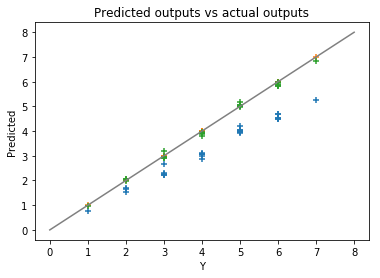

In [25]:
plt.title("Predicted outputs vs actual outputs")
plt.xlabel("Y")
plt.ylabel("Predicted")
z = np.arange(9)
plt.plot(z,z, c="grey")
plt.scatter(Y,predictions_bak,marker="+")
plt.scatter(Y,predictions_res,marker="+")
plt.scatter(Y,predictions_cli,marker="+")

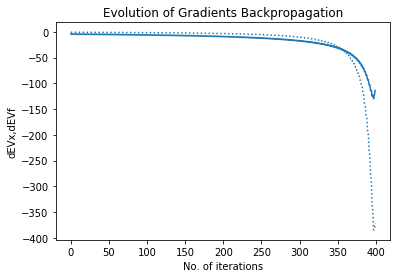

In [26]:
plt.title('Evolution of Gradients Backpropagation')
plt.xlabel('No. of iterations')
plt.ylabel('dEVx,dEVf')
#plt.ylim([-300,300])
#plt.xlim([0,100])
plt.plot(dEVx_bak, c="tab:blue")
plt.plot(dEVf_bak, linestyle=':', c="tab:blue")

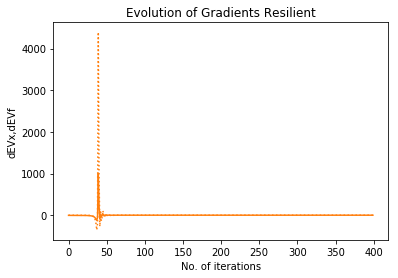

In [27]:
plt.title('Evolution of Gradients Resilient')
plt.xlabel('No. of iterations')
plt.ylabel('dEVx,dEVf')
#plt.ylim([-300,300])
#plt.xlim([0,100])
plt.plot(dEVx_res, c = "tab:orange")
plt.plot(dEVf_res, linestyle = ':', c = "tab:orange")

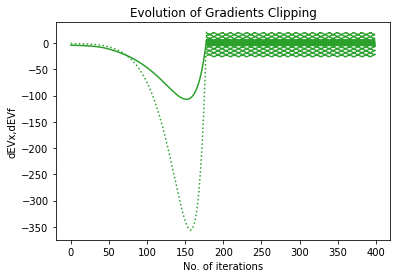

In [28]:
plt.title('Evolution of Gradients Clipping')
plt.xlabel('No. of iterations')
plt.ylabel('dEVx,dEVf')
#plt.ylim([-300,300])
#plt.xlim([0,100])
plt.plot(dEVx_cli, c = "tab:green")
plt.plot(dEVf_cli, linestyle = ':', c = "tab:green") 

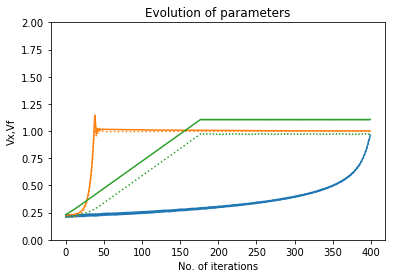

In [29]:
plt.title('Evolution of parameters')
plt.xlabel('No. of iterations')
plt.ylabel('Vx,Vf')
plt.ylim([0,2])
#plt.xlim([0,400])
plt.plot(Vx_bak, c="tab:blue")
plt.plot(Vf_bak, linestyle=':', c="tab:blue")
plt.plot(Vx_res, c = "tab:orange")
plt.plot(Vf_res, linestyle = ':', c = "tab:orange")
plt.plot(Vx_cli, c = "tab:green")
plt.plot(Vf_cli, linestyle = ':', c = "tab:green")       
#maybe limit window if iterations number have not the same scale


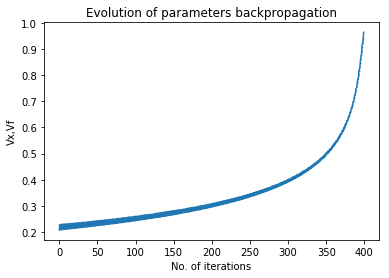

In [30]:
plt.title('Evolution of parameters backpropagation')
plt.xlabel('No. of iterations')
plt.ylabel('Vx,Vf')
plt.plot(Vx_bak, c="tab:blue")
plt.plot(Vf_bak, linestyle=':', c="tab:blue") 

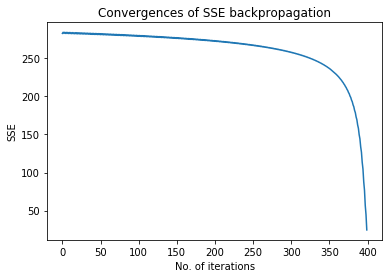

In [31]:
plt.title('Convergences of SSE backpropagation')
plt.xlabel('No. of iterations')
plt.ylabel('SSE')
plt.plot(SSE_bak)

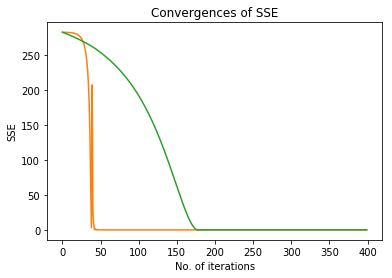

In [32]:
plt.title('Convergences of SSE')
plt.xlabel('No. of iterations')
plt.ylabel('SSE')
#plt.plot(SSE_bak)
plt.plot(SSE_res, c = "tab:orange")
plt.plot(SSE_cli, c = "tab:green")

## 4. Now, choose some (reasonably) large initial values for the model parameters and see the convergence for all three methods.

### Trainings (reasonably) large initial values for the model parameters

In [33]:
Vf_init = 5
Vx_init = 5

#### Back propagation:

In [34]:
Vx_bak, Vf_bak,dEVx_bak, dEVf_bak,SSE_bak = train_back(X,Y,alpha_x_bak,alpha_f_bak,epsilon, Vx_init, Vf_init)

Training # 1  Diff SSE:  1401  SSE :  1487169676160.0
dEVx : [1.48718753e+13] dEVf : [1.01075116e+14]
Vx : [-1.01075116e+10] Vf : [-1.48718752e+09]
__________________________________________________________________
Training # 2  Diff SSE:  1.8514278783748726e+149  SSE :  1.8514278783748726e+149
dEVx : [-8.10259273e+157] dEVf : [-3.85478861e+159]
Vx : [3.85478861e+155] Vf : [8.10259273e+153]
__________________________________________________________________
Training # 3  Diff SSE:  inf  SSE :  inf
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 4  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 5  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 6  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx :

/home/artyom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/home/artyom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/artyom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/artyom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()


Training # 59  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 60  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 61  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 62  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 63  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 64  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 65  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEV

Training # 118  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 119  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 120  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 121  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 122  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 123  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 124  Diff SSE:  nan  SSE :  nan
dEVx : [n

Training # 176  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 177  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 178  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 179  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 180  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 181  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 182  Diff SSE:  nan  SSE :  nan
dEVx : [n

Training # 235  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 236  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 237  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 238  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 239  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 240  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 241  Diff SSE:  nan  SSE :  nan
dEVx : [n

dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 296  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 297  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 298  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 299  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 300  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 301  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
____

Training # 355  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 356  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 357  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 358  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 359  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 360  Diff SSE:  nan  SSE :  nan
dEVx : [nan] dEVf : [nan]
Vx : [nan] Vf : [nan]
__________________________________________________________________
Training # 361  Diff SSE:  nan  SSE :  nan
dEVx : [n

In [35]:
index = np.argmin(SSE_bak)
Vx_b = Vx_bak[index]
Vf_b = Vf_bak[index]
print("Vx = ",Vx_b,"Vf = ",Vf_b)

Vx =  nan Vf =  nan


In [36]:
predictions_bak,F = forward_prop(X,Vx_b,Vf_b)

#### Resilient:

In [37]:
Vx_res,Vf_res,SSE_res = train_resilient(X,Y, delta_init, eta_p, eta_n, epsilon, Vx_init, Vf_init)

Training # 1  Diff SSE:  0.0  SSE :  1487169676160.0
dEVx : [1.48718753e+13] dEVf : [1.01075116e+14]
Vx : [4.99985] Vf : [4.99985]
delta_x : 0.00015 delta_f : 0.00015
__________________________________________________________________
Training # 2  Diff SSE:  695529311.4528809  SSE :  1486474146848.547
dEVx : [1.4864474e+13] dEVf : [1.01024688e+14]
Vx : [4.99967] Vf : [4.99967]
delta_x : 0.00017999999999999998 delta_f : 0.00017999999999999998
__________________________________________________________________
Training # 3  Diff SSE:  834232328.9785156  SSE :  1485639914519.5686
dEVx : [1.4855597e+13] dEVf : [1.00964205e+14]
Vx : [4.999454] Vf : [4.999454]
delta_x : 0.00021599999999999996 delta_f : 0.00021599999999999996
__________________________________________________________________
Training # 4  Diff SSE:  1000498986.7626953  SSE :  1484639415532.806
dEVx : [1.48449513e+13] dEVf : [1.00891671e+14]
Vx : [4.9991948] Vf : [4.9991948]
delta_x : 0.00025919999999999996 delta_f : 0.00025919

dEVx : [55.73165679] dEVf : [209.53705261]
Vx : [0.99955909] Vf : [0.99955909]
delta_x : 0.01777429326172292 delta_f : 0.01777429326172292
__________________________________________________________________
Training # 57  Diff SSE:  2.1306582066675466  SSE :  0.001266352895965003
dEVx : [-1.22885439] dEVf : [-4.50435838]
Vx : [1.00844624] Vf : [1.00844624]
delta_x : 0.00888714663086146 delta_f : 0.00888714663086146
__________________________________________________________________
Training # 58  Diff SSE:  0.48369645952467594  SSE :  0.48496281242064093
dEVx : [25.28301428] dEVf : [93.87320257]
Vx : [1.00400267] Vf : [1.00400267]
delta_x : 0.00444357331543073 delta_f : 0.00444357331543073
__________________________________________________________________
Training # 59  Diff SSE:  0.37835021956111536  SSE :  0.10661259285952555
dEVx : [11.56123554] dEVf : [42.65243645]
Vx : [0.99867038] Vf : [0.99867038]
delta_x : 0.005332287978516876 delta_f : 0.005332287978516876
______________________

Training # 111  Diff SSE:  2.0486206523271827e-21  SSE :  1.4205252526954544e-21
dEVx : [-1.3047512e-09] dEVf : [-4.785631e-09]
Vx : [1.] Vf : [1.]
delta_x : 5.977539398512236e-13 delta_f : 5.977539398512236e-13
__________________________________________________________________
Training # 112  Diff SSE:  1.3080782743990797e-21  SSE :  1.1244697829637464e-22
dEVx : [3.67091468e-10] dEVf : [1.3464474e-09]
Vx : [1.] Vf : [1.]
delta_x : 2.988769699256118e-13 delta_f : 2.988769699256118e-13
__________________________________________________________________
Training # 113  Diff SSE:  7.101301675421661e-23  SSE :  1.8345999505059126e-22
dEVx : [-4.68891814e-10] dEVf : [-1.71983094e-09]
Vx : [1.] Vf : [1.]
delta_x : 1.494384849628059e-13 delta_f : 1.494384849628059e-13
__________________________________________________________________
Training # 114  Diff SSE:  1.8130002447233647e-22  SSE :  2.1599705782547898e-24
dEVx : [-5.08793008e-11] dEVf : [-1.86609839e-10]
Vx : [1.] Vf : [1.]
delta_x : 

Training # 166  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 1.544346818147164e-13 delta_f : 1.544346818147164e-13
__________________________________________________________________
Training # 167  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 1.8532161817765967e-13 delta_f : 1.8532161817765967e-13
__________________________________________________________________
Training # 168  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 2.223859418131916e-13 delta_f : 2.223859418131916e-13
__________________________________________________________________
Training # 169  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 2.668631301758299e-13 delta_f : 2.668631301758299e-13
__________________________________________________________________
Training # 170  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 3.2023575621099587e-13 delta_

Training # 222  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 4.196571397656956e-09 delta_f : 4.196571397656956e-09
__________________________________________________________________
Training # 223  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 5.035885677188347e-09 delta_f : 5.035885677188347e-09
__________________________________________________________________
Training # 224  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 6.043062812626016e-09 delta_f : 6.043062812626016e-09
__________________________________________________________________
Training # 225  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 7.251675375151219e-09 delta_f : 7.251675375151219e-09
__________________________________________________________________
Training # 226  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 8.702010450181462e-09 delta_f :

Training # 277  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 9.503052945905837e-05 delta_f : 9.503052945905837e-05
__________________________________________________________________
Training # 278  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 0.00011403663535087004 delta_f : 0.00011403663535087004
__________________________________________________________________
Training # 279  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 0.00013684396242104403 delta_f : 0.00013684396242104403
__________________________________________________________________
Training # 280  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 0.00016421275490525282 delta_f : 0.00016421275490525282
__________________________________________________________________
Training # 281  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 0.00019705530588630336 de

Training # 334  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 3.0988044691454397 delta_f : 3.0988044691454397
__________________________________________________________________
Training # 335  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 3.7185653629745277 delta_f : 3.7185653629745277
__________________________________________________________________
Training # 336  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 4.462278435569433 delta_f : 4.462278435569433
__________________________________________________________________
Training # 337  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 5.35473412268332 delta_f : 5.35473412268332
__________________________________________________________________
Training # 338  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 6.425680947219984 delta_f : 6.425680947219984
_______________

Training # 391  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 101047.4127909894 delta_f : 101047.4127909894
__________________________________________________________________
Training # 392  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 121256.89534918728 delta_f : 121256.89534918728
__________________________________________________________________
Training # 393  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 145508.27441902473 delta_f : 145508.27441902473
__________________________________________________________________
Training # 394  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 174609.92930282967 delta_f : 174609.92930282967
__________________________________________________________________
Training # 395  Diff SSE:  0.0  SSE :  0.0
dEVx : [0.] dEVf : [0.]
Vx : [1.] Vf : [1.]
delta_x : 209531.9151633956 delta_f : 209531.9151633956
___________

ValueError: too many values to unpack (expected 3)

In [38]:
index = np.argmin(SSE_res)
Vx_r = Vx_res[index]
Vf_r = Vf_res[index]
print("Vx =",Vx_r,"Vf =",Vf_r)

Vx = 1.0009910995791054 Vf = 0.9997280003961976


In [39]:
predictions_res,F = forward_prop(X,Vx_r,Vf_r)

#### Clipping:

In [40]:
Vx_cli,Vf_cli,SSE_cli = train_clipping(X,Y, alpha_x_cli,alpha_f_cli,eta, epsilon,Vx_init,Vf_init)

Training # 1  Diff SSE:  0.0  SSE :  1487169676160.0
dEVx : [1.48718753e+13] dEVf : [1.01075116e+14]
Vx : [4.995] Vf : [4.995]
__________________________________________________________________
Training # 2  Diff SSE:  23020546839.010254  SSE :  1464149129320.9897
dEVx : [1.46270268e+13] dEVf : [9.9406878e+13]
Vx : [4.99] Vf : [4.99]
__________________________________________________________________
Training # 3  Diff SSE:  22685904821.833984  SSE :  1441463224499.1558
dEVx : [1.43859784e+13] dEVf : [9.77645929e+13]
Vx : [4.985] Vf : [4.985]
__________________________________________________________________
Training # 4  Diff SSE:  22355810742.363525  SSE :  1419107413756.7922
dEVx : [1.41486748e+13] dEVf : [9.61478823e+13]
Vx : [4.98] Vf : [4.98]
__________________________________________________________________
Training # 5  Diff SSE:  22030207110.81543  SSE :  1397077206645.9768
dEVx : [1.39150614e+13] dEVf : [9.4556372e+13]
Vx : [4.975] Vf : [4.975]
________________________________

Vx : [4.725] Vf : [4.725]
__________________________________________________________________
Training # 56  Diff SSE:  10223410142.91504  SSE :  616132999960.7798
dEVx : [5.822566e+12] dEVf : [3.94746513e+13]
Vx : [4.72] Vf : [4.72]
__________________________________________________________________
Training # 57  Diff SSE:  10066682707.375122  SSE :  606066317253.4047
dEVx : [5.72137418e+12] dEVf : [3.87867269e+13]
Vx : [4.715] Vf : [4.715]
__________________________________________________________________
Training # 58  Diff SSE:  9912201880.292603  SSE :  596154115373.112
dEVx : [5.62184046e+12] dEVf : [3.81101041e+13]
Vx : [4.71] Vf : [4.71]
__________________________________________________________________
Training # 59  Diff SSE:  9759937703.554688  SSE :  586394177669.5574
dEVx : [5.52393933e+12] dEVf : [3.74446085e+13]
Vx : [4.705] Vf : [4.705]
__________________________________________________________________
Training # 60  Diff SSE:  9609860588.46753  SSE :  576784317081.0898


Training # 113  Diff SSE:  4128833113.2407837  SSE :  234322401736.44708
dEVx : [2.08084656e+12] dEVf : [1.40649134e+13]
Vx : [4.435] Vf : [4.435]
__________________________________________________________________
Training # 114  Diff SSE:  4061672965.699463  SSE :  230260728770.74762
dEVx : [2.04247568e+12] dEVf : [1.38047619e+13]
Vx : [4.43] Vf : [4.43]
__________________________________________________________________
Training # 115  Diff SSE:  3995534483.979309  SSE :  226265194286.7683
dEVx : [2.00477202e+12] dEVf : [1.35491473e+13]
Vx : [4.425] Vf : [4.425]
__________________________________________________________________
Training # 116  Diff SSE:  3930403207.3979797  SSE :  222334791079.37033
dEVx : [1.96772469e+12] dEVf : [1.32979952e+13]
Vx : [4.42] Vf : [4.42]
__________________________________________________________________
Training # 117  Diff SSE:  3866264864.579651  SSE :  218468526214.79068
dEVx : [1.93132296e+12] dEVf : [1.30512326e+13]
Vx : [4.415] Vf : [4.415]
_____

Training # 173  Diff SSE:  1493767630.3815613  SSE :  79262097280.82286
dEVx : [6.56324918e+11] dEVf : [4.41944871e+12]
Vx : [4.135] Vf : [4.135]
__________________________________________________________________
Training # 174  Diff SSE:  1467804771.6105347  SSE :  77794292509.21233
dEVx : [6.43393191e+11] dEVf : [4.33206917e+12]
Vx : [4.13] Vf : [4.13]
__________________________________________________________________
Training # 175  Diff SSE:  1442264033.4087524  SSE :  76352028475.80357
dEVx : [6.3070179e+11] dEVf : [4.24631885e+12]
Vx : [4.125] Vf : [4.125]
__________________________________________________________________
Training # 176  Diff SSE:  1417139028.6964417  SSE :  74934889447.10713
dEVx : [6.18246519e+11] dEVf : [4.1621692e+12]
Vx : [4.12] Vf : [4.12]
__________________________________________________________________
Training # 177  Diff SSE:  1392423459.7981415  SSE :  73542465987.30899
dEVx : [6.0602325e+11] dEVf : [4.07959215e+12]
Vx : [4.115] Vf : [4.115]
_________

Training # 234  Diff SSE:  493149242.7591095  SSE :  24322405790.58525
dEVx : [1.86570831e+11] dEVf : [1.25037361e+12]
Vx : [3.83] Vf : [3.83]
__________________________________________________________________
Training # 235  Diff SSE:  483937881.05623627  SSE :  23838467909.529015
dEVx : [1.82620443e+11] dEVf : [1.22379287e+12]
Vx : [3.825] Vf : [3.825]
__________________________________________________________________
Training # 236  Diff SSE:  474887514.10619354  SSE :  23363580395.42282
dEVx : [1.7874897e+11] dEVf : [1.19774511e+12]
Vx : [3.82] Vf : [3.82]
__________________________________________________________________
Training # 237  Diff SSE:  465995522.4833565  SSE :  22897584872.939465
dEVx : [1.74954932e+11] dEVf : [1.17222031e+12]
Vx : [3.815] Vf : [3.815]
__________________________________________________________________
Training # 238  Diff SSE:  457259326.20015335  SSE :  22440325546.73931
dEVx : [1.71236873e+11] dEVf : [1.1472086e+12]
Vx : [3.81] Vf : [3.81]
__________

Training # 296  Diff SSE:  146275711.8530655  SSE :  6660327965.6069975
dEVx : [4.69640418e+10] dEVf : [3.12853284e+11]
Vx : [3.52] Vf : [3.52]
__________________________________________________________________
Training # 297  Diff SSE:  143319932.62880802  SSE :  6517008032.978189
dEVx : [4.58883609e+10] dEVf : [3.05653956e+11]
Vx : [3.515] Vf : [3.515]
__________________________________________________________________
Training # 298  Diff SSE:  140420062.00092983  SSE :  6376587970.97726
dEVx : [4.48359336e+10] dEVf : [2.98610944e+11]
Vx : [3.51] Vf : [3.51]
__________________________________________________________________
Training # 299  Diff SSE:  137575115.1604681  SSE :  6239012855.816792
dEVx : [4.38062874e+10] dEVf : [2.91721057e+11]
Vx : [3.505] Vf : [3.505]
__________________________________________________________________
Training # 300  Diff SSE:  134784123.35660553  SSE :  6104228732.460186
dEVx : [4.27989587e+10] dEVf : [2.84981168e+11]
Vx : [3.5] Vf : [3.5]
____________

Training # 356  Diff SSE:  40853048.995872974  SSE :  1711147827.6218467
dEVx : [1.10409943e+10] dEVf : [7.29999659e+10]
Vx : [3.22] Vf : [3.22]
__________________________________________________________________
Training # 357  Diff SSE:  39956906.47038746  SSE :  1671190921.1514592
dEVx : [1.07665068e+10] dEVf : [7.1174961e+10]
Vx : [3.215] Vf : [3.215]
__________________________________________________________________
Training # 358  Diff SSE:  39079173.396687984  SSE :  1632111747.7547712
dEVx : [1.04984629e+10] dEVf : [6.93930211e+10]
Vx : [3.21] Vf : [3.21]
__________________________________________________________________
Training # 359  Diff SSE:  38219497.42677736  SSE :  1593892250.3279939
dEVx : [1.02367203e+10] dEVf : [6.76531909e+10]
Vx : [3.205] Vf : [3.205]
__________________________________________________________________
Training # 360  Diff SSE:  37377532.45816827  SSE :  1556514717.8698256
dEVx : [9.98113967e+09] dEVf : [6.59545347e+10]
Vx : [3.2] Vf : [3.2]
_________

ValueError: too many values to unpack (expected 3)

In [41]:
index = np.argmin(SSE_cli)
Vx_c = Vx_cli[index]
Vf_c = Vf_cli[index]
print("Vx =",Vx_c,"Vf =",Vf_c)

Vx = 1.1029118705925154 Vf = 0.9696331896027763


In [42]:
predictions_cli,F = forward_prop(X,Vx_c,Vf_c)

### Plotting comparison #2

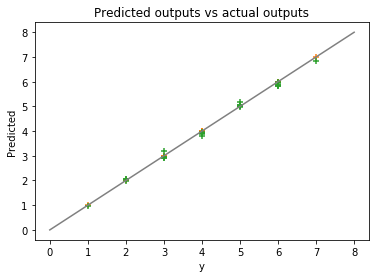

In [43]:
plt.title("Predicted outputs vs actual outputs")
plt.xlabel("y")
plt.ylabel("Predicted")
z = np.arange(9)
plt.plot(z,z, c="grey")
plt.scatter(Y,predictions_bak,marker="+")
plt.scatter(Y,predictions_res,marker="+")
plt.scatter(Y,predictions_cli,marker="+")

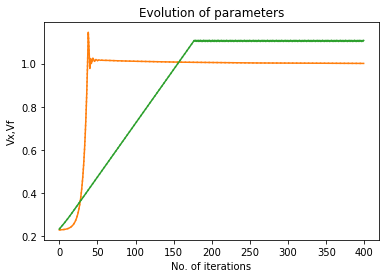

In [44]:
plt.title('Evolution of parameters')
plt.xlabel('No. of iterations')
plt.ylabel('Vx,Vf')
#plt.plot(Vx_bak, c="tab:blue")
#plt.plot(Vf_bak, linestyle=':', c="tab:blue")
plt.plot(Vx_res, c = "tab:orange")
plt.plot(Vx_res, linestyle = ':', c = "tab:orange")
plt.plot(Vx_cli, c = "tab:green")
plt.plot(Vx_cli, linestyle = ':', c = "tab:green")       
#maybe limit window if iterations number have not the same scale

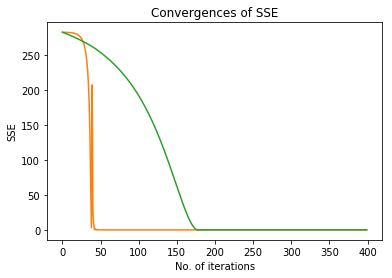

In [45]:
plt.title('Convergences of SSE')
plt.xlabel('No. of iterations')
plt.ylabel('SSE')
#plt.plot(SSE_bak)
plt.plot(SSE_res, c = "tab:orange")
plt.plot(SSE_cli, c = "tab:green")

## 5. Test your model with all three methods (backpropagation, resilient propagation and gradient clipping) by generating some new test data and compare the results.

In [46]:
I=30      #number of examples test
T=8       #Length of the bit sequence

X_test = np.random.binomial(n, p, T*I)     #One random bit sequences
X_test = X.reshape((I, T))                 #Reshaped (I,T)
  
Y_test = []
for i in X_test:
    Y_test = np.append(Y_test,np.sum(i))   #Creation of ground truth outputs for testing
Y_test = Y_test.reshape(I,1)

#### Backpropagation

In [47]:
index = np.argmin(SSE_bak)
Vx_c = Vx_bak[index]
Vf_c = Vf_bak[index]
predictions_bak,F = forward_prop(X,Vx_c,Vf_c)

#### Resilient

In [48]:
index = np.argmin(SSE_res)
Vx_r = Vx_res[index]
Vf_r = Vf_res[index]
predictions_res,F = forward_prop(X,Vx_r,Vf_r)

#### Clipping

In [49]:
index = np.argmin(SSE_cli)
Vx_c = Vx_cli[index]
Vf_c = Vf_cli[index]
predictions_cli,F = forward_prop(X,Vx_c,Vf_c)

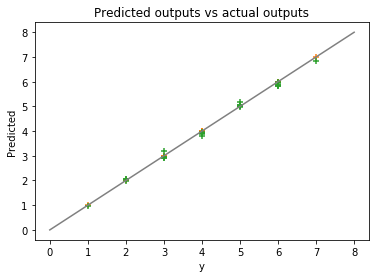

In [50]:
plt.title("Predicted outputs vs actual outputs")
plt.xlabel("y")
plt.ylabel("Predicted")
z = np.arange(9)
plt.plot(z,z, c="grey")
plt.scatter(Y_test,predictions_bak,marker="+")
plt.scatter(Y_test,predictions_res,marker="+")
plt.scatter(Y_test,predictions_cli,marker="+")